In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import seaborn as sns

### Feature Selection using hybrid approach ###

In [2]:
#https://github.com/comet-ml/comet-content/blob/master/home-credit/data/eda-part-1.ipynb
df = pd.read_csv('credit_date_df.csv', index_col=0)

In [3]:
#one-hot encoding
df = pd.get_dummies(df, columns = ['year', 'month','product_term_credit_limit'])

In [4]:
# integer valued features
integer_df = df.select_dtypes(include=['int'])
integer_df.drop(columns=['NP'], axis=1, inplace=True)

# some integer features are actually categorical features. So we need to extract these columns
binary_cols = [col for col in integer_df if (list(integer_df[col].unique()) == [0, 1]) or (list(integer_df[col].unique()) == [1, 0])]
integer_df.shape

(19030, 1490)

In [5]:
# float valued features
float_df = df.select_dtypes(exclude=['int', 'object'])
float_df.shape

(19030, 855)

In [6]:
# categorical features
categorical_df = df.select_dtypes(exclude=['int', 'float'])
categorical_df.shape

(19030, 19)

In [7]:
X_categorical = pd.concat([categorical_df, integer_df[binary_cols]], axis=1)

In [8]:
X_categorical.head()

,year_2019,year_2020,year_2021,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,product_term_credit_limit_300,product_term_credit_limit_500,product_term_credit_limit_750,product_term_credit_limit_1000,cash_intent
record_nb,,,,,,,,,,,,,,,,,,,,
1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0
2,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0
3,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0
4,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0
5,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1


In [9]:
# pca transformation function
from sklearn.decomposition import PCA
from sklearn import preprocessing

def do_pca(df):
    robust_scaler = preprocessing.RobustScaler()
    scaled_x_b = robust_scaler.fit_transform(df) 
    min_max_scaler = preprocessing.MinMaxScaler()
    X_normalized = min_max_scaler.fit_transform(scaled_x_b)

    pca = PCA(n_components=10)
    components = pca.fit_transform(X_normalized)
    columns = ['pca-{}'.format(i+1) for i in range(len(components[0,:]))]
    
    return (pca, pd.DataFrame(components, columns=columns))

## Visualizing the Top 10 Most Correlated Features

In [10]:
from sklearn.ensemble import RandomForestClassifier
    
def rf_feature_plot(df, title):
    rf = RandomForestClassifier(n_estimators=100, max_leaf_nodes=31)
    rf.fit(df, y)

    features = list(df.columns)
    importances = rf.feature_importances_
    indices = np.argsort(importances).tolist()

    _tmp = indices[::-1][:10]
    _x = range(len(_tmp))

    feature_labels = [features[i] for i in _tmp]
    top_importance = [importances[i] for i in _tmp]

    plt.figure(figsize=(8,5))
    plt.barh(_x, top_importance[::-1], color='b', align='center')
    plt.yticks(_x, feature_labels[::-1], fontsize=14)
    plt.xlabel('Relative Importance')
    plt.show()
    return feature_labels

In [11]:
#!pip install lightgbm

In [12]:
import lightgbm as lgb
import matplotlib.pyplot as plt

def lightgbm_feature_plot(df, y, title):
    train_data = lgb.Dataset(data=df, label=y, feature_name=list(df.columns))
    param = {'num_leaves':31, 'num_trees':100, 'objective':'binary', 'metric' : 'auc'}
    num_round = 10
    
    bst = lgb.train(param, train_data, num_round)
    ax = lgb.plot_importance(bst, max_num_features=10, figsize=(8,5), height=0.5)

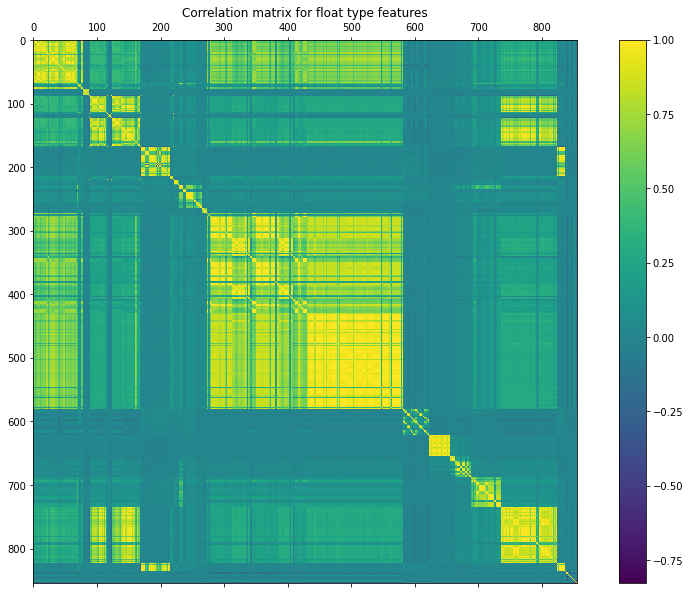

In [13]:
# plot correlation matrix for float type features
float_columns = list(float_df.columns)
float_corr = float_df.corr()

fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)
cax = ax.matshow(float_corr, interpolation='nearest')
plt.title("Correlation matrix for float type features")
fig.colorbar(cax)

From the correlation graph, We see that features 280 to 590 are highly correlated, and on further inspection with data dictionary, we find that these features are all related to open/closed trades and unsatisfied medical collections. These features are good candidates for dimensionality reduction, since they are adding redundant information to the model.

In [14]:
# Select float features for pca transformation
pca_candidates = float_df.iloc[:, 280:590]
pca_candidates = pca_candidates.fillna(method='ffill')
pca_candidates = pca_candidates.fillna(method='bfill')
pca, X_pca = do_pca(pca_candidates)

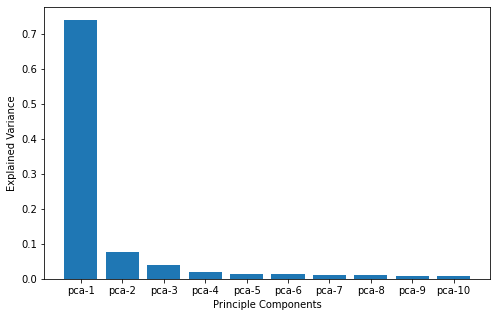

In [15]:
plt.figure(figsize=(8,5))
plt.bar(X_pca.columns, pca.explained_variance_ratio_)
plt.ylabel('Explained Variance')
plt.xlabel('Principle Components')
plt.show()

These 10 components are able to explain 70% of variance in the dataset and we can use these top 10 principle components in our dataset

In [16]:
# Drop pca candidate features from float_df
# Drop categorical features from integer_df
float_columns = list(float_df.columns)

float_df.drop(columns=float_columns[280:590], inplace=True, axis=1)
integer_df.drop(columns=binary_cols, inplace=True, axis=1)

integer_df.fillna(method='ffill', inplace=True)
float_df.fillna(method='ffill', inplace=True)
float_df.fillna(method='bfill', inplace=True)

In [17]:
y = df['NP']

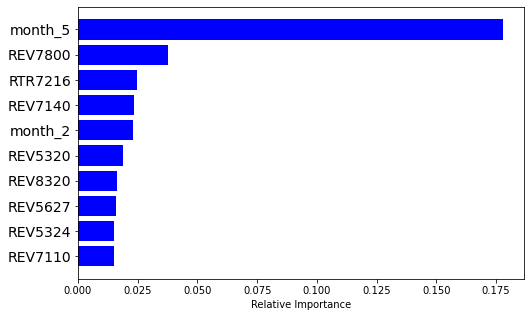

['month_5',
 'REV7800',
 'RTR7216',
 'REV7140',
 'month_2',
 'REV5320',
 'REV8320',
 'REV5627',
 'REV5324',
 'REV7110']

In [18]:
rf_feature_plot(float_df, 'RF Float Feature Importance')

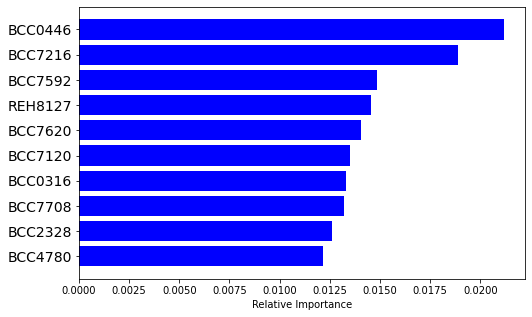

['BCC0446',
 'BCC7216',
 'BCC7592',
 'REH8127',
 'BCC7620',
 'BCC7120',
 'BCC0316',
 'BCC7708',
 'BCC2328',
 'BCC4780']

In [19]:
rf_feature_plot(integer_df, 'RF Integer Feature Importance')

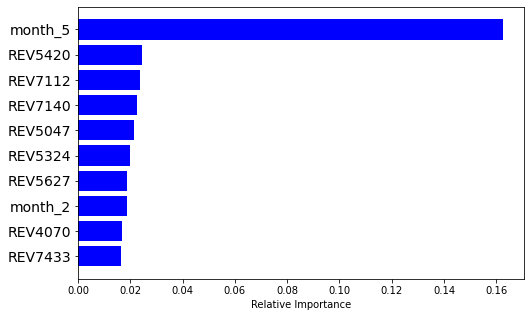

['month_5',
 'REV5420',
 'REV7112',
 'REV7140',
 'REV5047',
 'REV5324',
 'REV5627',
 'month_2',
 'REV4070',
 'REV7433']

In [20]:
rf_feature_plot(float_df, 'RF Float Feature Importance')

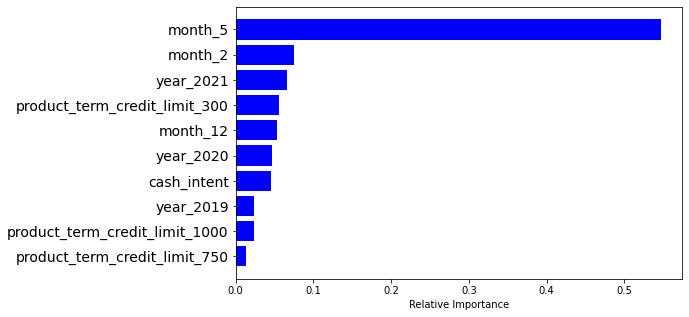

['month_5',
 'month_2',
 'year_2021',
 'product_term_credit_limit_300',
 'month_12',
 'year_2020',
 'cash_intent',
 'year_2019',
 'product_term_credit_limit_1000',
 'product_term_credit_limit_750']

In [21]:
rf_feature_plot(X_categorical, 'RF Categorical Feature Importance')

[LightGBM] [Info] Number of positive: 1725, number of negative: 17305
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.063893 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 48309
[LightGBM] [Info] Number of data points in the train set: 19030, number of used features: 542
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.090646 -> initscore=-2.305768
[LightGBM] [Info] Start training from score -2.305768


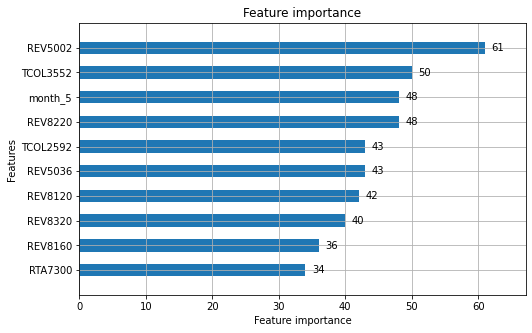

In [22]:
lightgbm_feature_plot(float_df, df['NP'], 'LightGBM Float Feature Importance')


[LightGBM] [Info] Number of positive: 1725, number of negative: 17305
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.252698 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 113363
[LightGBM] [Info] Number of data points in the train set: 19030, number of used features: 1466
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.090646 -> initscore=-2.305768
[LightGBM] [Info] Start training from score -2.305768


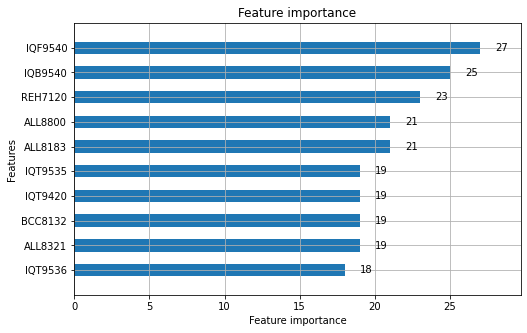

In [23]:
lightgbm_feature_plot(integer_df, df['NP'],'LightGBM Integer Feature Importance')

[LightGBM] [Info] Number of positive: 1725, number of negative: 17305
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000218 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 34
[LightGBM] [Info] Number of data points in the train set: 19030, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.090646 -> initscore=-2.305768
[LightGBM] [Info] Start training from score -2.305768


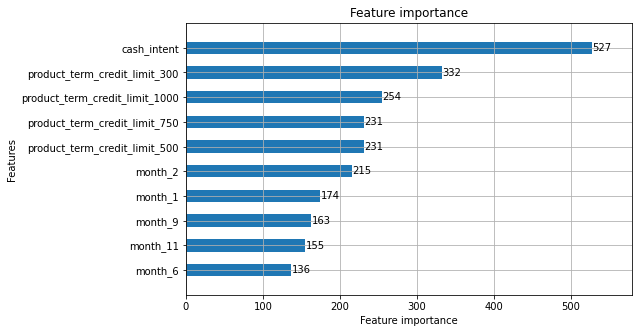

In [24]:
lightgbm_feature_plot(X_categorical, df['NP'], 'LightGBM Categorical Feature Importance')

In [25]:
scaler = preprocessing.StandardScaler()
normalized_integer_df = pd.DataFrame(scaler.fit_transform(integer_df))

float_df.fillna(method='bfill', inplace=True)
normalized_float_df = pd.DataFrame(scaler.fit_transform(float_df))

In [26]:
normalized_integer_df.columns = integer_df.columns

In [27]:
normalized_float_df.columns = float_df.columns

In [28]:
X_final = pd.concat([normalized_float_df, normalized_integer_df, X_categorical, X_pca], axis=1)
X_final.shape

(19031, 2064)

In [29]:
df2 = X_final.iloc[:-1 , :]
df2.shape

(19030, 2064)

In [30]:
duplicate_columns = df2.columns[df2.columns.duplicated()]
duplicate_columns

Index(['year_2019', 'year_2020', 'year_2021', 'month_1', 'month_2', 'month_3',
       'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9',
       'month_10', 'month_11', 'month_12', 'product_term_credit_limit_300',
       'product_term_credit_limit_500', 'product_term_credit_limit_750',
       'product_term_credit_limit_1000'],
      dtype='object')

In [31]:
df2 = df2.loc[:,~df2.columns.duplicated()]

In [32]:
df2.head()

,REV2386,REV2387,REV2388,REV2800,REV2840,REV2841,REV3421,REV3422,REV3423,REV3424,...,pca-1,pca-2,pca-3,pca-4,pca-5,pca-6,pca-7,pca-8,pca-9,pca-10
0,-0.358011,-0.350418,-0.350334,-0.360122,-0.325039,-0.321443,-0.317410,-0.324718,-0.300444,-0.330074,...,-3.665676,-1.221405,-0.375095,0.702833,0.062604,-0.147777,-0.500548,0.709393,-0.186736,-0.146841
1,-0.358011,-0.350418,-0.350334,-0.241074,-0.206610,-0.203108,-0.417478,-0.424110,-0.365736,-0.395869,...,-3.702221,-0.635955,-0.012819,0.158782,0.787528,-0.000278,0.058157,-1.205359,0.185972,0.050169
2,-0.358011,-0.350418,-0.350334,-0.360122,-0.325039,-0.321443,-0.017206,-0.192194,-0.365736,-0.330074,...,-3.817392,-0.907924,-0.174371,0.802488,0.678649,-0.209219,-0.214954,-0.926349,-0.581115,-0.710501
3,2.801470,-0.113042,0.328783,0.393849,-0.246086,-0.321443,2.784698,2.789586,2.800904,2.795183,...,12.161778,-0.464254,-0.309820,0.509713,-0.469378,1.986522,-1.081139,0.341374,-0.073534,0.103716
4,-0.358011,-0.350418,-0.350334,-0.241074,-0.325039,-0.321443,-0.417478,-0.390979,-0.365736,-0.362971,...,-2.987944,0.003054,-0.099155,-0.982005,-0.398232,0.267276,-0.816511,0.582415,1.717663,0.246754


In [33]:
#fill the null values
df2 = df2.fillna(0)

In [34]:
from sklearn import model_selection
from statistics import mean, stdev
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score,f1_score,precision_score, recall_score,auc,roc_curve
import time

In [35]:
X = df2
Y = df['NP']
MLA_columns = []
MLA_compare = pd.DataFrame(columns = MLA_columns)
row_index = 0
# prepare configuration for cross validation test harness
seed = 7
# prepare models
models = []
models.append(('Logistic Regression', LogisticRegression()))
models.append(('XGBoost', XGBClassifier(eval_metric='mlogloss')))

# evaluate each model in turn
results = []
names = []
scoring = 'accuracy'

# Create StratifiedKFold object.    
tic = time.perf_counter()
for name, model in models:
    skfold = model_selection.StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
    cv_results = model_selection.cross_val_score(model, X, Y, cv=skfold, scoring=scoring)
    f1_results = model_selection.cross_val_score(model, X, Y, cv=skfold, scoring='f1')
    recall_results = model_selection.cross_val_score(model, X, Y, cv=skfold, scoring='recall')
    precision_results = model_selection.cross_val_score(model, X, Y, cv=skfold, scoring='precision')
    MLA_compare.loc[row_index,'MLA used'] = name
    MLA_compare.loc[row_index, 'Test Accuracy'] = round(mean(cv_results), 4)
    MLA_compare.loc[row_index, 'Precision'] = round(mean(precision_results),4)
    MLA_compare.loc[row_index, 'Recall'] = round(mean(recall_results),4)
    MLA_compare.loc[row_index, 'f1'] = mean(f1_results)
    results.append(cv_results)
    names.append(name)
    # Print the output.
    print('List of possible accuracies for {0} is: {1}'.format(name, cv_results))
    print('List of possible Precision for {0} is: {1}'.format(name, precision_results))
    print('List of possible Recall for {0} is: {1}'.format(name, recall_results))
    print('List of possible F1 score for {0} is: {1}'.format(name, f1_results))
    msg = "%s: %f (%f)" % (name, mean(cv_results), cv_results.std())
    print(msg)
    toc = time.perf_counter()
    secs = toc - tic
    print("---Classifier %s use %0.4f seconds ---" %(name, secs))
    row_index+=1
    
MLA_compare.sort_values(by = ['Test Accuracy'], ascending = False, inplace = True)    
MLA_compare

List of possible accuracies for Logistic Regression is: [0.91854966 0.92643195 0.91907514 0.92275355 0.92143983]
List of possible Precision for Logistic Regression is: [0.62411348 0.72727273 0.64341085 0.71794872 0.66911765]
List of possible Recall for Logistic Regression is: [0.25507246 0.30144928 0.24057971 0.24347826 0.26376812]
List of possible F1 score for Logistic Regression is: [0.36213992 0.42622951 0.35021097 0.36363636 0.37837838]
Logistic Regression: 0.921650 (0.002842)
---Classifier Logistic Regression use 105.9307 seconds ---
List of possible accuracies for XGBoost is: [0.92354178 0.92170257 0.9224908  0.92301629 0.92616921]
List of possible Precision for XGBoost is: [0.69565217 0.67407407 0.71186441 0.7826087  0.73529412]
List of possible Recall for XGBoost is: [0.27826087 0.26376812 0.24347826 0.20869565 0.28985507]
List of possible F1 score for XGBoost is: [0.39751553 0.37916667 0.36285097 0.32951945 0.41580042]
XGBoost: 0.923384 (0.001519)
---Classifier XGBoost use 103

,MLA used,Test Accuracy,Precision,Recall,f1
1,XGBoost,0.9234,0.7199,0.2568,0.376971
0,Logistic Regression,0.9217,0.6764,0.2609,0.376119


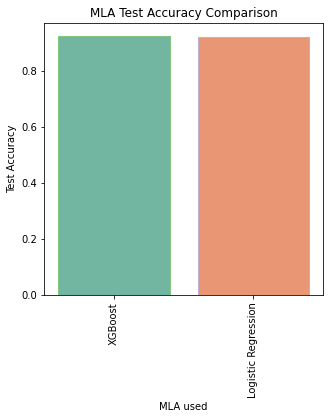

In [36]:
# Creating plot to show the train accuracy
plt.subplots(figsize=(5,5))
sns.barplot(x="MLA used", y="Test Accuracy",data=MLA_compare,palette='Set2',edgecolor=sns.color_palette('Accent',7))
plt.xticks(rotation=90)
plt.title('MLA Test Accuracy Comparison')
plt.show()